# Import Libraries

In [16]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Loading Dataset

In [105]:
conn = sqlite3.connect('jobs2.db')
query = "SELECT * FROM jobs_cleaned_table WHERE job_group NOT IN ('Others');"
df = pd.read_sql_query(query,conn)
conn.close()

# EDA

## Count by job group

In [18]:
job_groups_counts = df['job_group'].value_counts()
job_groups_counts

job_group
Financial Analyst            42572
Business Analyst             39692
Data Analyst                 35225
Controller                   21433
Data Scientist               20116
Data Engineer                17927
Analyst                      16486
ML/AI Engineer               14628
Business Intelligence        13300
Accountant                   13098
Software Engineer             9117
CFO                           8432
Operations Analyst            8178
Engineer                      5794
Finance                       2299
Statistician/Mathemathics     1688
Name: count, dtype: int64

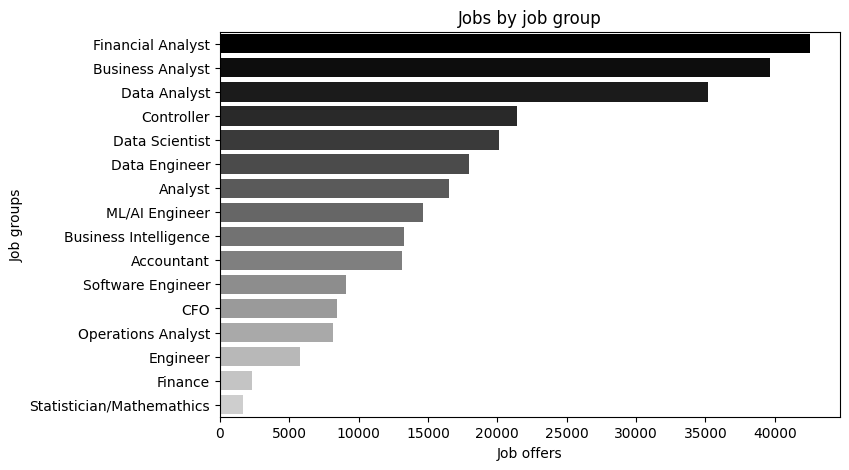

In [19]:
def plot_bars(x,y,figsize=(8,5),title=None,xlabel=(None),ylabel=(None),palette=None):

    plt.figure(figsize=figsize)
    cmap = plt.cm.get_cmap(palette).reversed()
    palette = [cmap(x) for x in np.linspace(0,0.7,len(job_groups_counts))]

    sns.barplot(x=x,y=y,palette=palette)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_bars(x=job_groups_counts.values,y=job_groups_counts.index,title='Jobs by job group',xlabel='Job offers',ylabel='Job groups',palette='Greys')

## Count by year

In [107]:
df['year'] = df['date_posted'].astype(str).str[:4]
df = df[df['year'].str.isnumeric()]
df['year'] = df['year'].astype(int)
postings_by_year = df['year'].value_counts().sort_index()
postings_by_year

year
1986         1
1987         3
1989         2
1993         1
1998         1
2006         1
2007         2
2008         1
2009         1
2013         1
2014         1
2015         7
2017         4
2018         8
2019         9
2020        26
2021        16
2022       149
2023    124034
2024    145135
Name: count, dtype: int64

In [114]:
def plot_multiple_bars(df, columns, category=None, figsize=(10,12), count_percentage=False, 
                      x_y=False, top_10=False, list_values=False, aggregate_column=None,
                      group_by=None, sort_by=None, custom_colors=None):
    """
    Plot multiple bar charts based on column values.
    
    Parameters:
    -----------
    columns : list
        List of columns to plot.
    category : str, optional
        Column to use for grouping data into separate plots.
    figsize : tuple, optional
        Figure size for the entire plot.
    count_percentage : bool, optional
        Whether to display count and percentage on bars.
    x_y : bool, optional
        If True, swap x and y axes.
    top_10 : bool, optional
        If True, show only top 10 values.
    list_values : bool, optional
        If True, split comma-separated values and count them individually.
    aggregate_column : str, optional
        Column to aggregate (mean) instead of counting values.
    group_by : str, optional
        Si se proporciona, crea barras dobles agrupadas por esta columna.
    sort_by : str, optional
        Cómo ordenar las barras: 'asc', 'desc', o nombre de un valor en group_by.
    custom_colors : list, optional
        Lista de colores personalizados para las barras agrupadas.
    """

    rows = df[category].unique() if category is not None else ['Total']
    n_rows, n_cols = len(rows), len(columns)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)

    category_palettes = {
        'Financial Analyst': 'Purples',
        'Business Analyst': 'Oranges',
        'Data Analyst': 'Blues',
        'Controller': 'Greys',
        'Data Scientist': 'Greens',
        'Data Engineer': 'Reds',
        'Analyst': 'YlGnBu',
        'ML/AI Engineer': 'YlOrRd',
        'Business Intelligence': 'PuBuGn',
        'Accountant': 'BuPu',
        'Software Engineer': 'OrRd',
        'CFO': 'GnBu',
        'Operations Analyst': 'RdPu',
        'Engineer': 'YlGn',
        'Finance': 'PuRd',
        'Statistician/Mathemathics': 'BrBG'
    }

    # Definir colores personalizados para las barras agrupadas
    default_group_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Colores por defecto
    if custom_colors:
        group_colors = custom_colors
    else:
        group_colors = default_group_colors

    for i, row in enumerate(rows):
        group_data = df[df[category] == row] if category is not None else df

        for j, column in enumerate(columns):
            ax = axes[i, j]
            
            # Configure axes appearance
            for spine in ax.spines.values():
                spine.set_visible(False)
                
            # Process for standard single bars
            if group_by is None:
                if aggregate_column is None:
                    if top_10 and list_values is False:
                        column_top = group_data[column].value_counts().head(10)
                
                    elif list_values is not False and top_10 is None:
                        column_top = (group_data[column].str.split(', ').explode()
                                    .value_counts()
                                    .dropna()
                                    .sort_values(ascending=False))
                        column_top = column_top.drop(labels='', errors='ignore')
                    
                    elif list_values is not False and top_10 is not None:
                        column_top = (group_data[column].str.split(', ').explode()
                                    .value_counts()
                                    .dropna()
                                    .sort_values(ascending=False).head(10))
                        column_top = column_top.drop(labels='', errors='ignore')
                    
                    else:
                        column_top = group_data[column].value_counts()
                
                else:
                    grouped = (
                        group_data.explode(column)
                        .groupby(column)[aggregate_column]
                        .mean()
                        .sort_values(ascending=False)
                    )

                    if list_values:
                        group_data = group_data.reset_index(drop=True)
                        grouped = pd.DataFrame({
                            column: group_data[column].str.split(', ').explode(),
                            aggregate_column: group_data[aggregate_column]
                        })
                        grouped = grouped.groupby(column)[aggregate_column].mean().sort_values(ascending=False)

                    if '' in grouped.index:
                        grouped = grouped.drop('')
                    
                    column_top = grouped.head(10) if top_10 else grouped

                total = group_data[column].count()

                if category is not None:
                    palette = category_palettes.get(row, 'Blues')
                    cmap = plt.cm.get_cmap(palette).reversed()
                    palette = [cmap(x) for x in np.linspace(0, 0.7, len(column_top))]
                else:
                    cmap = plt.cm.get_cmap('Greys').reversed()
                    palette = [cmap(x) for x in np.linspace(0, 0.7, len(column_top))]

                kwargs = {
                    'y': column_top.values,
                    'x': column_top.index
                } if x_y else {
                    'x': column_top.values,
                    'y': column_top.index
                }

                sns.barplot(ax=ax, palette=palette, **kwargs)
                
                # Set labels
                aggregate_label = 'Count' if aggregate_column is None else f'Avg {aggregate_column}'
                ax.set_title(f'{row}: {aggregate_label} by {column}')
                ax.set_xlabel(aggregate_label if not x_y else column)
                ax.set_ylabel(column if not x_y else aggregate_label)

                # Add annotations if requested
                if count_percentage:
                    for k, value in enumerate(column_top.values):
                        percentage = value / total * 100
                        annotation_kwargs = {
                            'text': f'{value:.1f} ({percentage:.1f}%)',
                            'xy': (k, value) if x_y else (value, k),
                            'xytext': (-30, 5) if x_y else (5, 0),
                            'textcoords': 'offset points',
                            'va': 'center',
                            'ha': 'left',
                            'fontsize': 10,
                            'color': 'black'
                        }
                        ax.annotate(**annotation_kwargs)
            
            # Process for grouped bars (when group_by is provided)
            else:
                # Get unique values for the grouping variable
                group_values = group_data[group_by].unique()
                if len(group_values) > 5:  # Limitar para evitar gráficos demasiado complejos
                    print(f"Advertencia: {group_by} tiene más de 5 valores. Usando solo los 5 más frecuentes.")
                    # Obtener los 5 valores más frecuentes
                    group_values = group_data[group_by].value_counts().nlargest(5).index.tolist()
                
                # Determine categories to plot
                if list_values:
                    all_categories = set()
                    for val in group_data[column].dropna():
                        if isinstance(val, str) and ',' in val:
                            all_categories.update([v.strip() for v in val.split(',')])
                    categories = sorted(list(all_categories))
                    if top_10:
                        # Contar ocurrencias para determinar top 10
                        category_counts = {}
                        for val in group_data[column].dropna():
                            if isinstance(val, str) and ',' in val:
                                for v in val.split(','):
                                    v = v.strip()
                                    category_counts[v] = category_counts.get(v, 0) + 1
                        categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:10]
                        categories = [c[0] for c in categories]
                else:
                    # Determinar categorías y ordenar si es necesario
                    if sort_by:
                        # Preparar data para ordenamiento
                        categories_data = {}
                        for cat in group_data[column].unique():
                            if sort_by == 'asc' or sort_by == 'desc':
                                # Ordenar por la suma/promedio total
                                if aggregate_column:
                                    val = group_data[group_data[column] == cat][aggregate_column].mean()
                                else:
                                    val = group_data[group_data[column] == cat].shape[0]
                                categories_data[cat] = val
                            else:
                                # Ordenar por un valor específico de group_by
                                try:
                                    sort_group_data = group_data[(group_data[column] == cat) & (group_data[group_by] == sort_by)]
                                    if aggregate_column:
                                        val = sort_group_data[aggregate_column].mean() if not sort_group_data.empty else 0
                                    else:
                                        val = sort_group_data.shape[0]
                                    categories_data[cat] = val
                                except:
                                    # Si el valor de sort_by no existe, usar 0
                                    categories_data[cat] = 0
                        
                        # Ordenar las categorías
                        reverse_order = sort_by != 'asc'
                        categories = sorted(categories_data.items(), key=lambda x: x[1], reverse=reverse_order)
                        categories = [c[0] for c in categories]
                    else:
                        categories = group_data[column].value_counts().index.tolist()
                    
                    if top_10:
                        categories = categories[:10]
                
                # Create grouped bar chart
                bar_width = 0.8 / len(group_values)  # Ajustar ancho según número de grupos
                x = np.arange(len(categories))
                
                for idx, g_value in enumerate(group_values):
                    g_data = group_data[group_data[group_by] == g_value]
                    
                    if aggregate_column is None:
                        if list_values:
                            # Para datos con valores separados por comas
                            values = []
                            for cat in categories:
                                count = 0
                                for val in g_data[column].dropna():
                                    if isinstance(val, str) and cat in [v.strip() for v in val.split(',')]:
                                        count += 1
                                values.append(count)
                        else:
                            # Contar ocurrencias normales
                            value_counts = g_data[column].value_counts()
                            values = [value_counts.get(cat, 0) for cat in categories]
                        
                        label = f'{g_value}'
                    else:
                        if list_values:
                            # Para datos agregados con valores separados por comas
                            values = []
                            for cat in categories:
                                avg_values = []
                                for idx_row, val in enumerate(g_data[column].dropna()):
                                    if isinstance(val, str) and cat in [v.strip() for v in val.split(',')]:
                                        avg_values.append(g_data.iloc[idx_row][aggregate_column])
                                values.append(np.mean(avg_values) if avg_values else 0)
                        else:
                            # Calcular promedios normales
                            grouped = g_data.groupby(column)[aggregate_column].mean()
                            values = [grouped.get(cat, 0) for cat in categories]
                            
                        label = f'{g_value} (Avg {aggregate_column})'
                    
                    # Posicionar cada barra
                    position = x + (idx - len(group_values)/2 + 0.5) * bar_width
                    
                    # Usar color personalizado para este grupo
                    color = group_colors[idx % len(group_colors)]
                    
                    if x_y:
                        ax.barh(position, values, bar_width, label=label, color=color)
                    else:
                        ax.bar(position, values, bar_width, label=label, color=color)
                
                # Set ticks
                if x_y:
                    ax.set_yticks(x)
                    ax.set_yticklabels(categories, rotation=0)
                else:
                    ax.set_xticks(x)
                    ax.set_xticklabels(categories, rotation=90 if len(categories) > 5 else 0)
                
                # Add legend
                ax.legend(title=group_by)
                
                # Set labels
                aggregate_label = 'Count' if aggregate_column is None else f'Avg {aggregate_column}'
                ax.set_title(f'{row}: {aggregate_label} by {column} agrupado por {group_by}')
                
                if x_y:
                    ax.set_xlabel(aggregate_label)
                    ax.set_ylabel(column)
                else:
                    ax.set_xlabel(column)
                    ax.set_ylabel(aggregate_label)

    plt.tight_layout()
    plt.show()


year = ('year',)

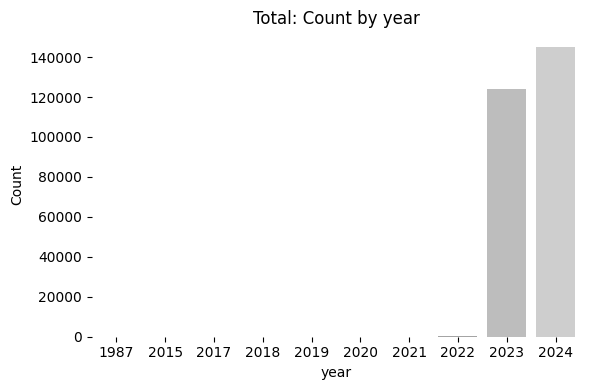

In [22]:
plot_multiple_bars(year,figsize=(6,4), x_y=True, top_10=True)

In [108]:
df = df[df['year'].isin([2023, 2024])]

# Market Job Analysis

## Skills by job group

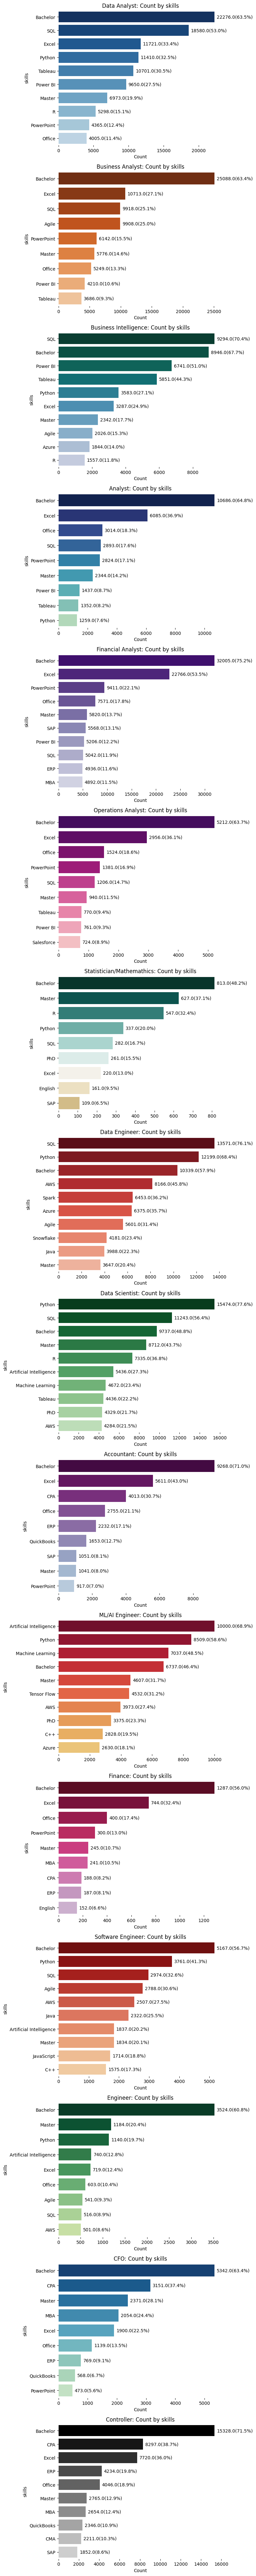

In [24]:
columns_skills = ['skills',]
plot_multiple_bars(columns_skills,category='job_group',figsize=(8,80),top_10=True, list_values=True,count_percentage=True)

## Location by job group

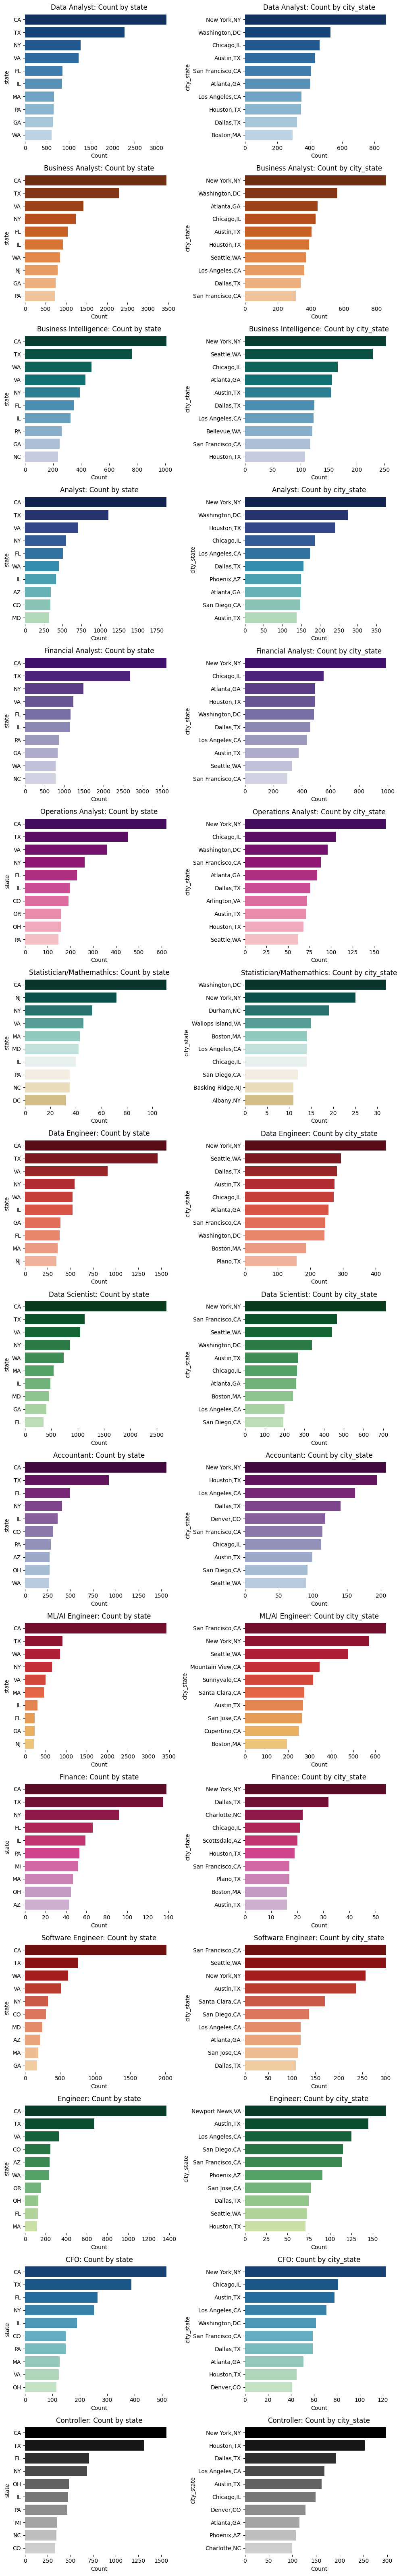

In [25]:
columns_location = ['state','city_state']
plot_multiple_bars(columns_location,category='job_group',figsize=(10,64),top_10=True)

# Salaries

## Salary by job group

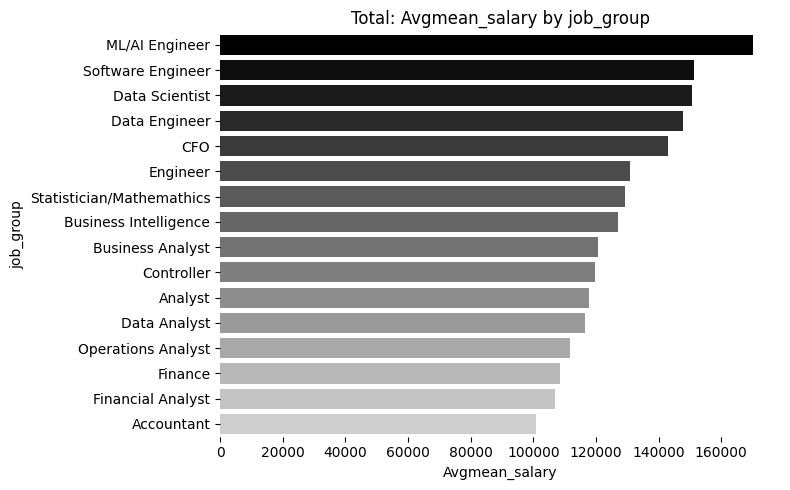

In [26]:
columns_job_group = ['job_group']
plot_multiple_bars(columns_job_group,figsize=(8,5),aggregate_column='mean_salary')

## Salary by state

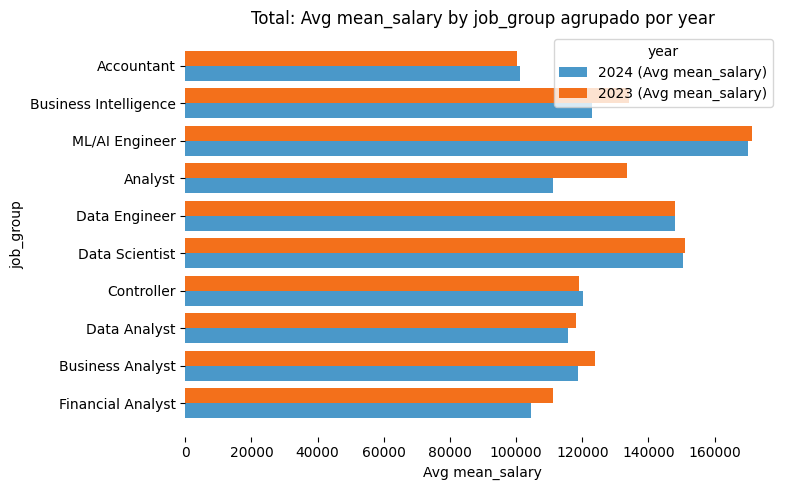

## Salaries 2024 vs 2023

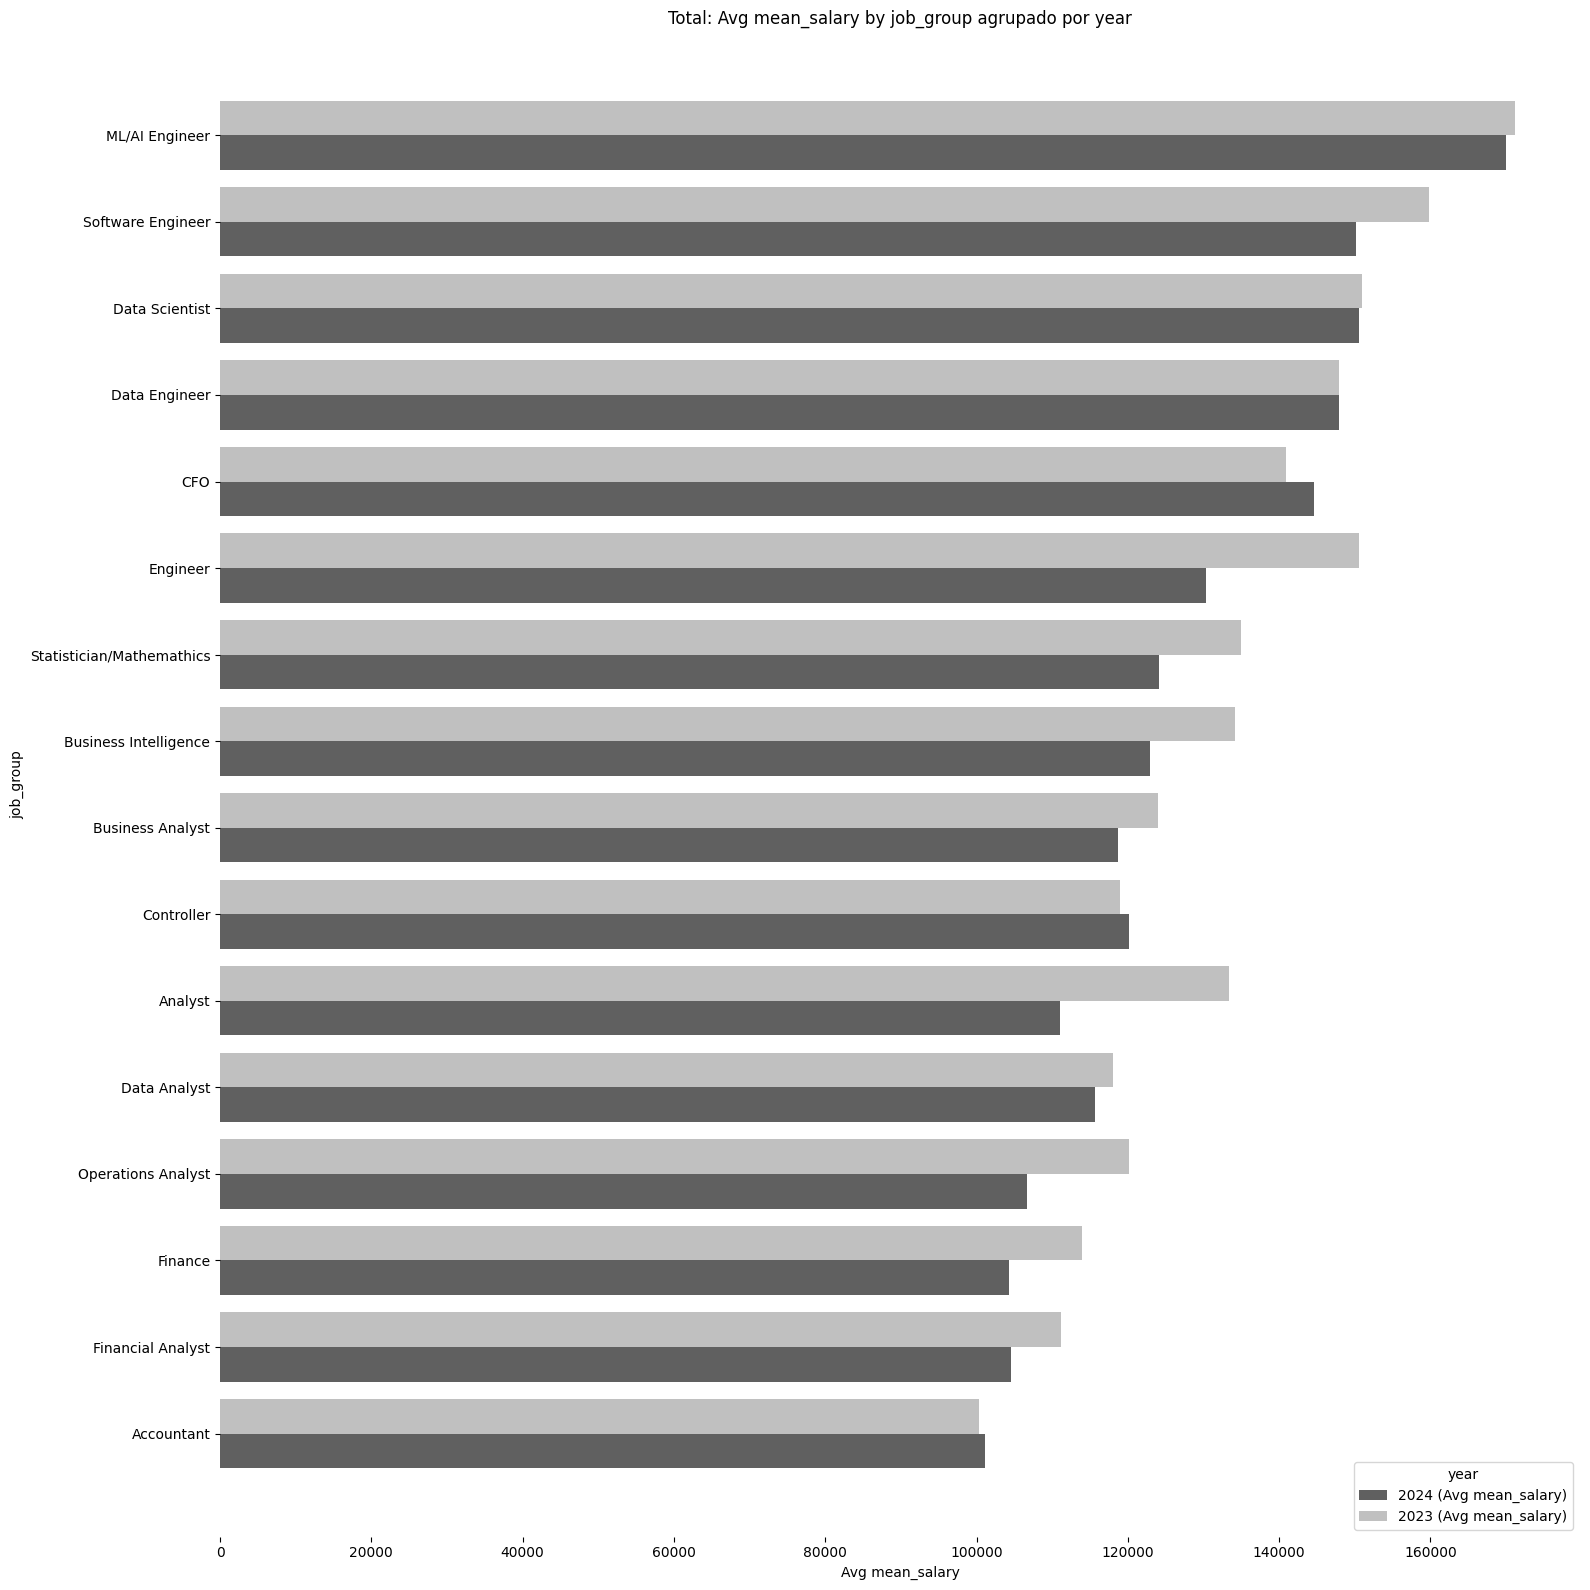

In [59]:
custom_colors = ['#606060', '#C0C0C0']
# Para ordenar según los salarios de 2024
plot_multiple_bars(
    columns=['job_group'], 
    figsize=(16,16),
    top_10=False, 
    x_y=True,
    aggregate_column='mean_salary', 
    group_by='year',
    sort_by='asc',  # Ordenar por los valores de 2024
    custom_colors=custom_colors
)

## Salaries Data vs Finance

In [110]:
def classify_group(job_group):
    data_roles = ['ML/AI Engineer', 'Data Scientist', 'Data Analyst', 'Data Engineer', 'Business Intelligence']
    finance_roles = ['CFO', 'Controller', 'Finance', 'Financial Analyst', 'Accountant']

    if job_group in data_roles:
        return 'Data'
    elif job_group in finance_roles:
        return 'Finance'
    else:
        return 'Others'

df['data_finance'] = df['job_group'].apply(classify_group)

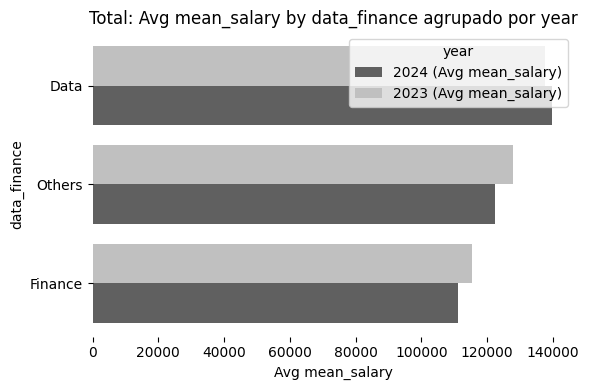

In [70]:
plot_multiple_bars(
    columns=['data_finance'], 
    figsize=(6,4),
    top_10=False, 
    x_y=True,
    aggregate_column='mean_salary', 
    group_by='year',
    sort_by='asc',  # Ordenar por los valores de 2024
    custom_colors=custom_colors
)

## Top Skills by Salary

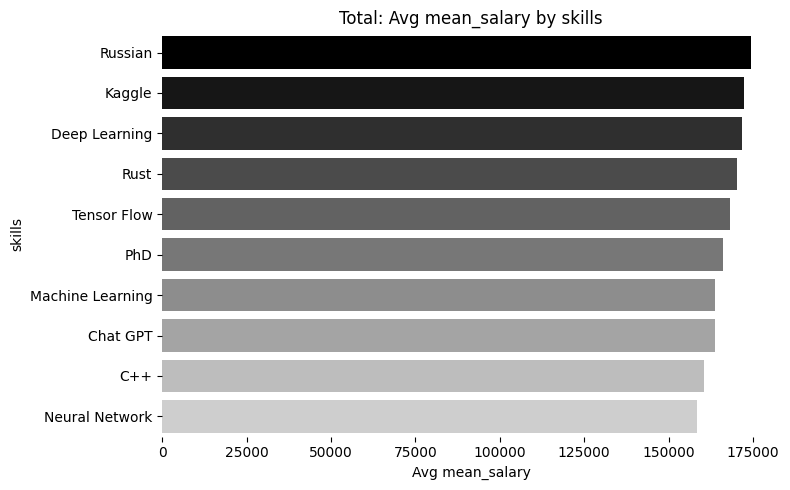

In [82]:
df['skills']
plot_multiple_bars(columns_skills,figsize=(8,5), list_values=True, top_10=True, aggregate_column='mean_salary')

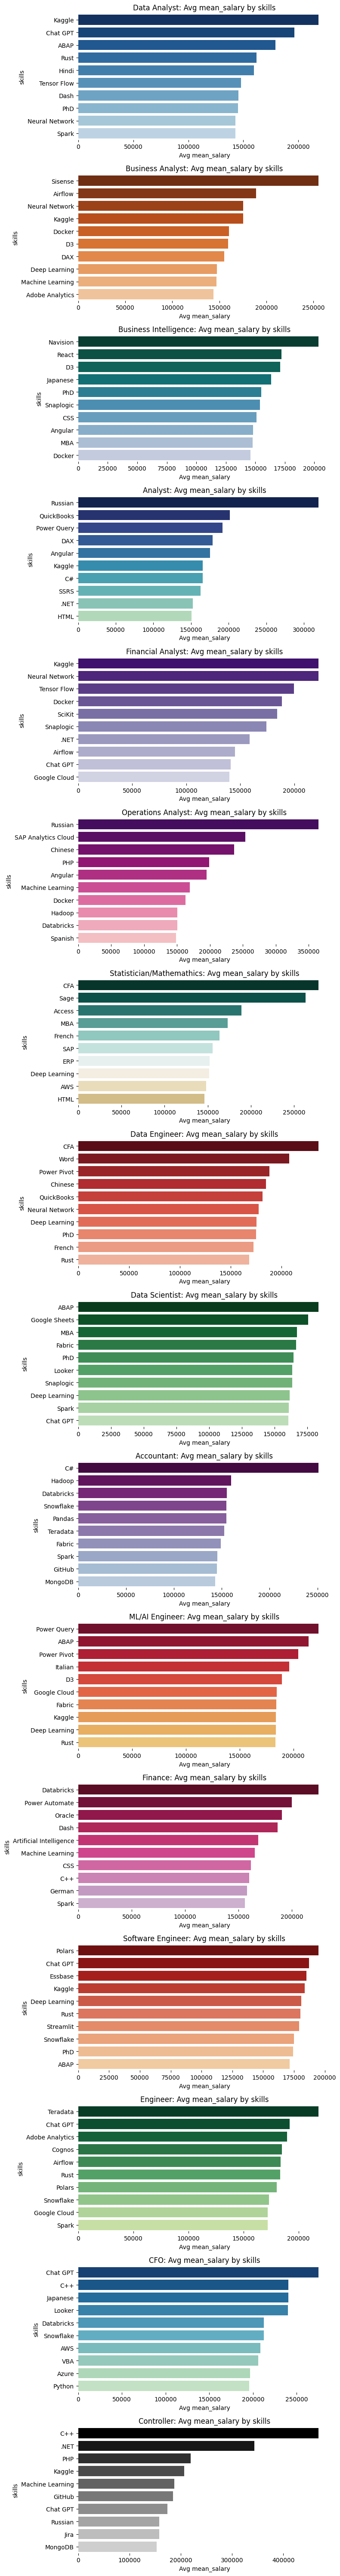

In [89]:
plot_multiple_bars(columns_skills,category='job_group',figsize=(8,60), list_values=True, top_10=True, aggregate_column='mean_salary')

# Skills

## Count by skills

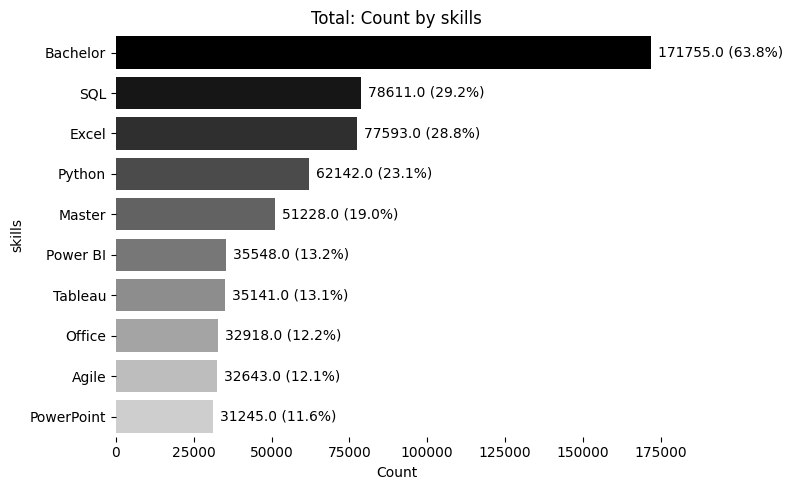

In [90]:
plot_multiple_bars(columns_skills,figsize=(8,5),list_values=True,count_percentage=True)

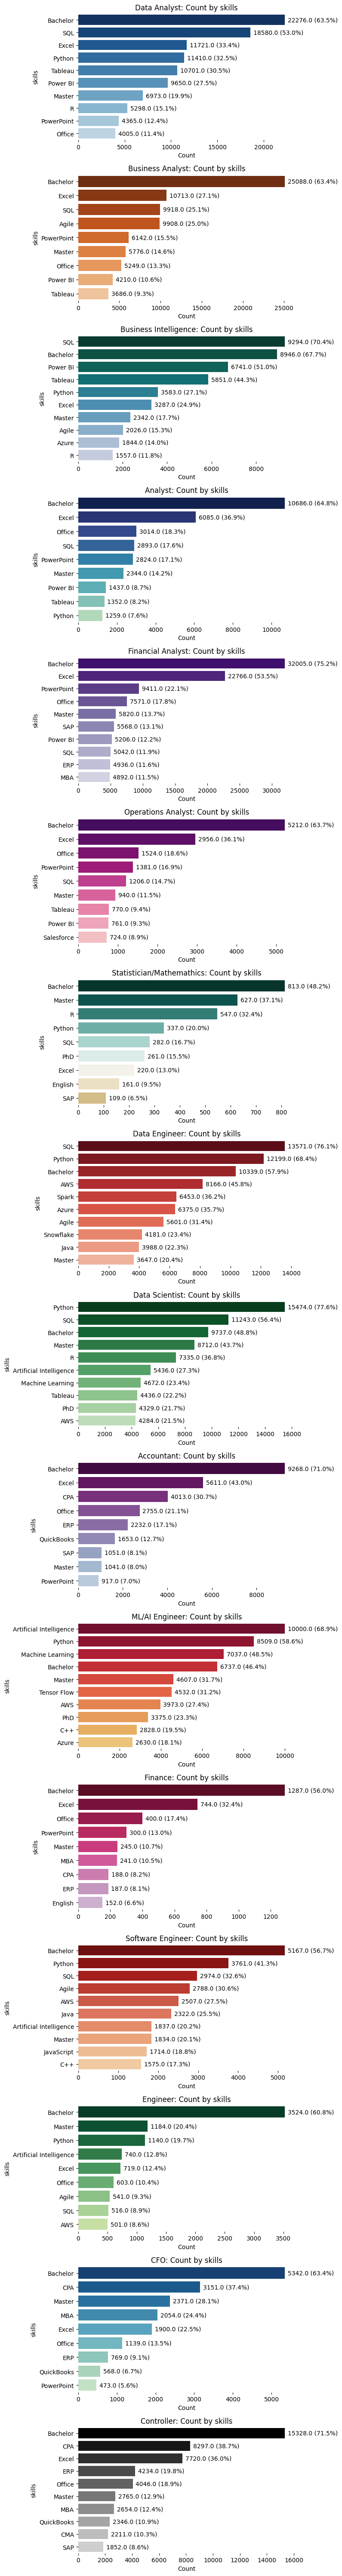

In [92]:
plot_multiple_bars(columns_skills,category='job_group',figsize=(8,60),list_values=True,count_percentage=True)

## Count by Education

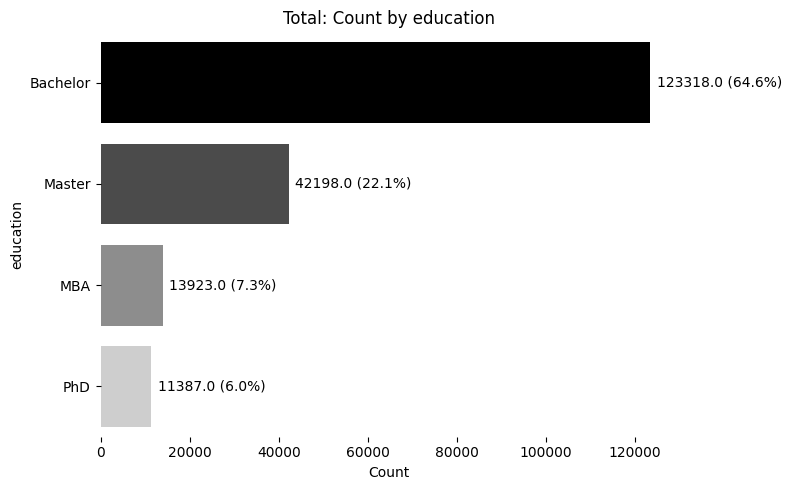

In [93]:
columns_education = ('education',)

plot_multiple_bars(columns_education,figsize=(8,5),count_percentage=True)

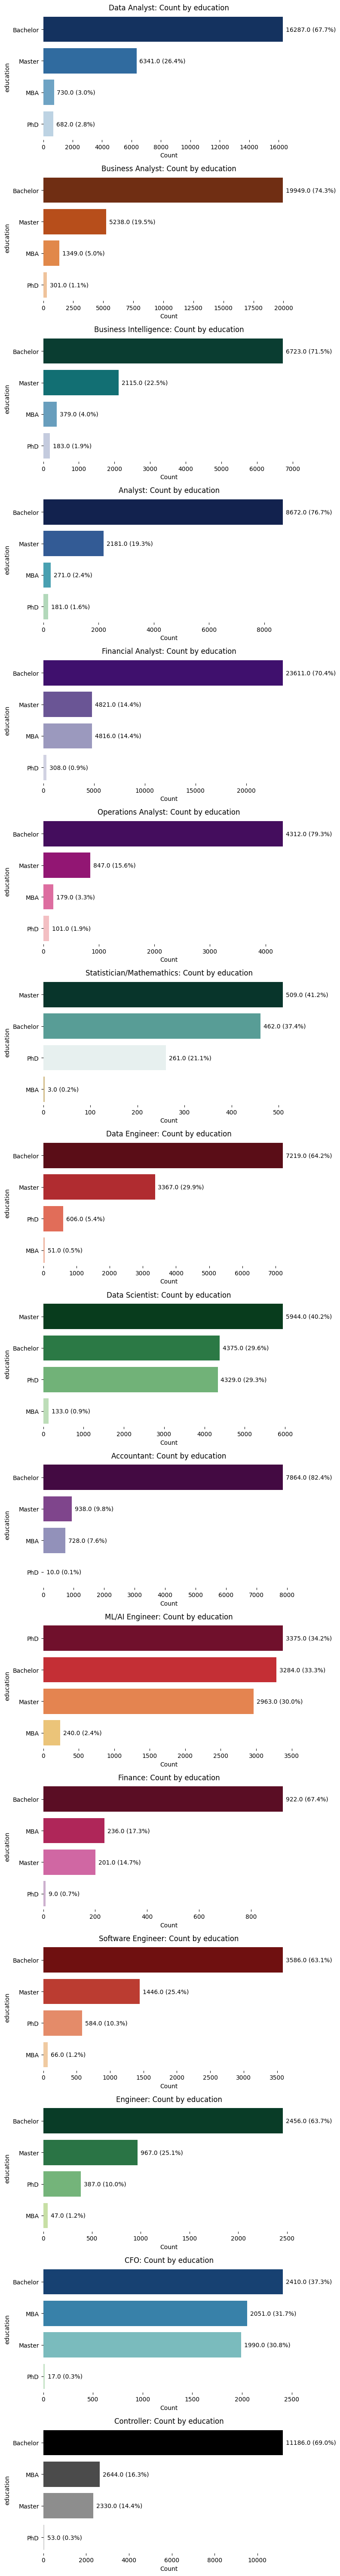

In [95]:
plot_multiple_bars(columns_education,category='job_group',figsize=(8,60),count_percentage=True)

## Count by Experience

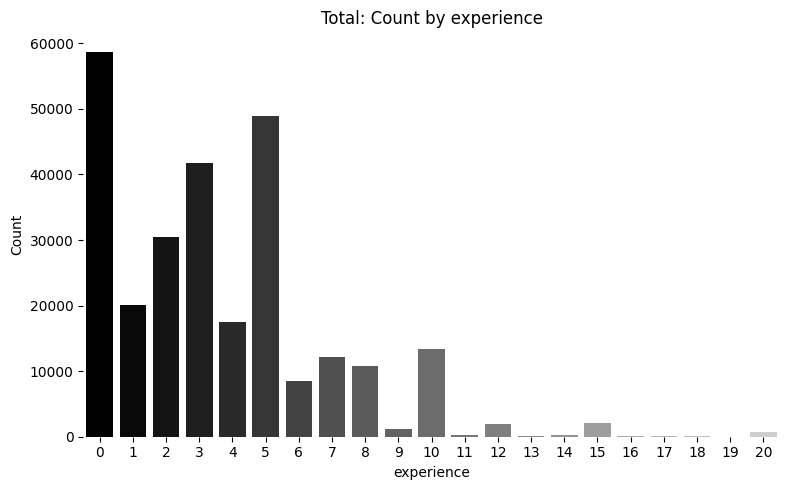

In [96]:
columns_experience = ('experience',)

plot_multiple_bars(columns_experience,figsize=(8,5),x_y=True)

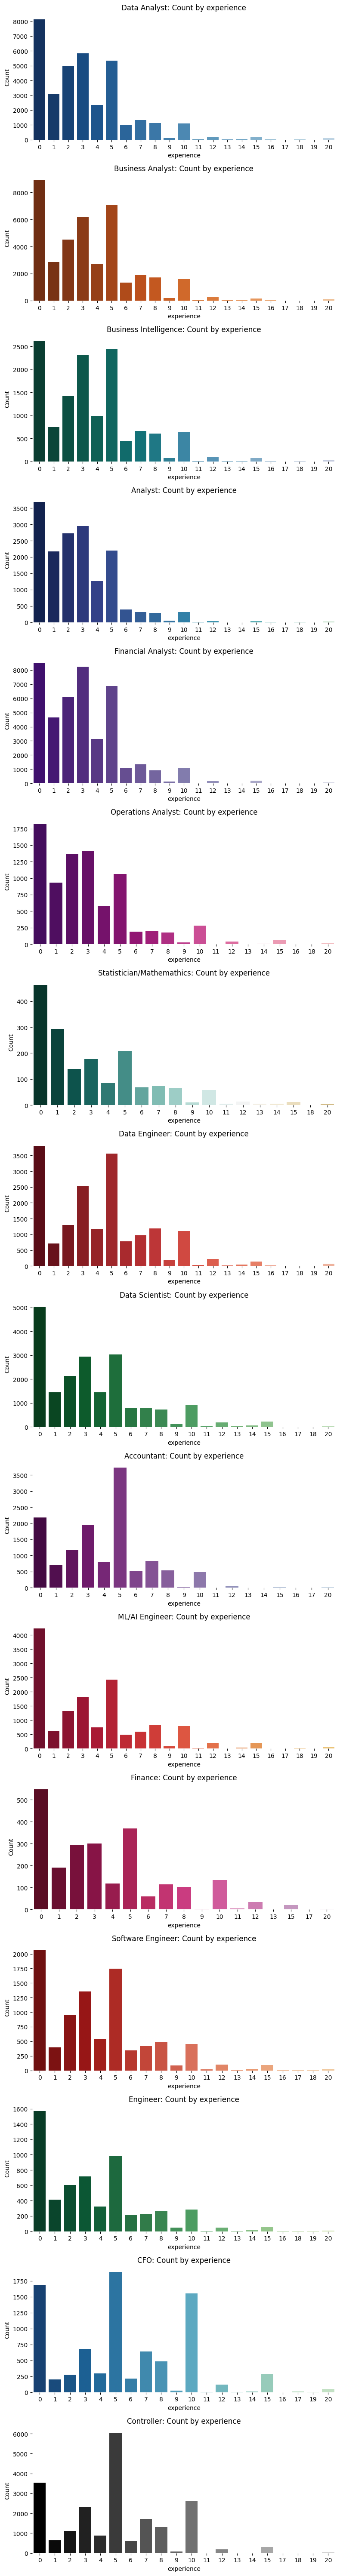

In [98]:
plot_multiple_bars(columns_experience,category='job_group',figsize=(8,60),x_y=True)

## Skills by year (most growth)

In [99]:
import pandas as pd
import re

# Supongamos que tienes un dataframe con columnas 'skills' y 'year'
# Primero debes cargar tus datos
# df = pd.read_csv('tu_archivo.csv')

# Ejemplo de código para generar datos de prueba
# Puedes reemplazar esto con tu propio código para cargar datos reales
def crear_datos_ejemplo():
    data = [
        {'skills': 'Python, SQL, Data Analysis', 'year': 2023},
        {'skills': 'Python, JavaScript, SQL', 'year': 2023},
        {'skills': 'Java, Python, Cloud', 'year': 2023},
        {'skills': 'Python, Data Analysis, AI', 'year': 2023},
        {'skills': 'JavaScript, HTML, CSS', 'year': 2023},
        {'skills': 'Python, SQL, Data Analysis', 'year': 2024},
        {'skills': 'Python, JavaScript, SQL', 'year': 2024},
        {'skills': 'Python, JavaScript, SQL', 'year': 2024},
        {'skills': 'Java, Python, Cloud', 'year': 2024},
        {'skills': 'Python, Data Analysis, AI', 'year': 2024},
        {'skills': 'Python, Data Analysis, AI', 'year': 2024},
        {'skills': 'AI, Machine Learning, Python', 'year': 2024},
        {'skills': 'JavaScript, HTML, CSS', 'year': 2024},
        {'skills': 'AI, JavaScript, React', 'year': 2024},
    ]
    return pd.DataFrame(data)

# Carga tus datos o usa el ejemplo
df = crear_datos_ejemplo()

# Función para procesar el campo 'skills' y contar cada habilidad
def contar_skills_por_año(dataframe):
    resultados = {}
    
    # Procesamos cada año (2023 y 2024)
    for año in [2023, 2024]:
        # Filtramos los datos para el año actual
        df_año = dataframe[dataframe['year'] == año]
        
        # Diccionario para contar las skills en este año
        conteo_skills = {}
        
        # Iteramos sobre cada fila y procesamos la columna 'skills'
        for skills in df_año['skills']:
            # Separamos las skills por comas y limpiamos espacios
            lista_skills = [skill.strip() for skill in skills.split(',')]
            
            # Incrementamos el contador para cada skill
            for skill in lista_skills:
                if skill in conteo_skills:
                    conteo_skills[skill] += 1
                else:
                    conteo_skills[skill] = 1
        
        # Guardamos los resultados para este año
        resultados[año] = conteo_skills
    
    return resultados

# Ejecutamos la función para obtener los conteos por año
conteos = contar_skills_por_año(df)

# Creamos una lista con todas las skills únicas
todas_skills = set()
for año in conteos:
    todas_skills.update(conteos[año].keys())

# Creamos un dataframe para comparar los años
comparacion = []
for skill in todas_skills:
    count_2023 = conteos.get(2023, {}).get(skill, 0)
    count_2024 = conteos.get(2024, {}).get(skill, 0)
    variation = count_2024 - count_2023
    variation_percent = (variation / count_2023 * 100) if count_2023 > 0 else float('inf')
    
    comparacion.append({
        'skill': skill,
        'count_2023': count_2023,
        'count_2024': count_2024,
        'variation': variation,
        'variation_percent': variation_percent
    })

# Convertimos a dataframe y ordenamos por variación descendente
df_comparacion = pd.DataFrame(comparacion)
df_comparacion = df_comparacion.sort_values(by='variation', ascending=False)

# Obtenemos el top 10
top_10 = df_comparacion.head(10)

# Mostramos la tabla
print("Top 10 skills con mayor aumento de 2023 a 2024:")
print(top_10[['skill', 'count_2023', 'count_2024', 'variation']])

Top 10 skills con mayor aumento de 2023 a 2024:
              skill  count_2023  count_2024  variation
1                AI           1           4          3
8            Python           4           7          3
2        JavaScript           2           4          2
0             React           0           1          1
5     Data Analysis           2           3          1
7               SQL           2           3          1
9  Machine Learning           0           1          1
3             Cloud           1           1          0
4               CSS           1           1          0
6              Java           1           1          0


# Data

## Count by Level

In [112]:
df_data = df[df['data_finance']== 'Data'] 

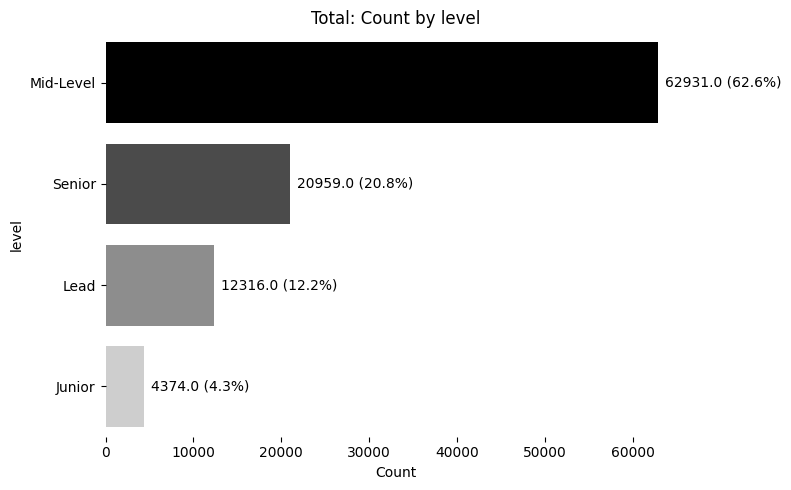

In [116]:
columns_level = ['level',]
plot_multiple_bars(df_data, columns_level,figsize=(8,5),count_percentage=True) 

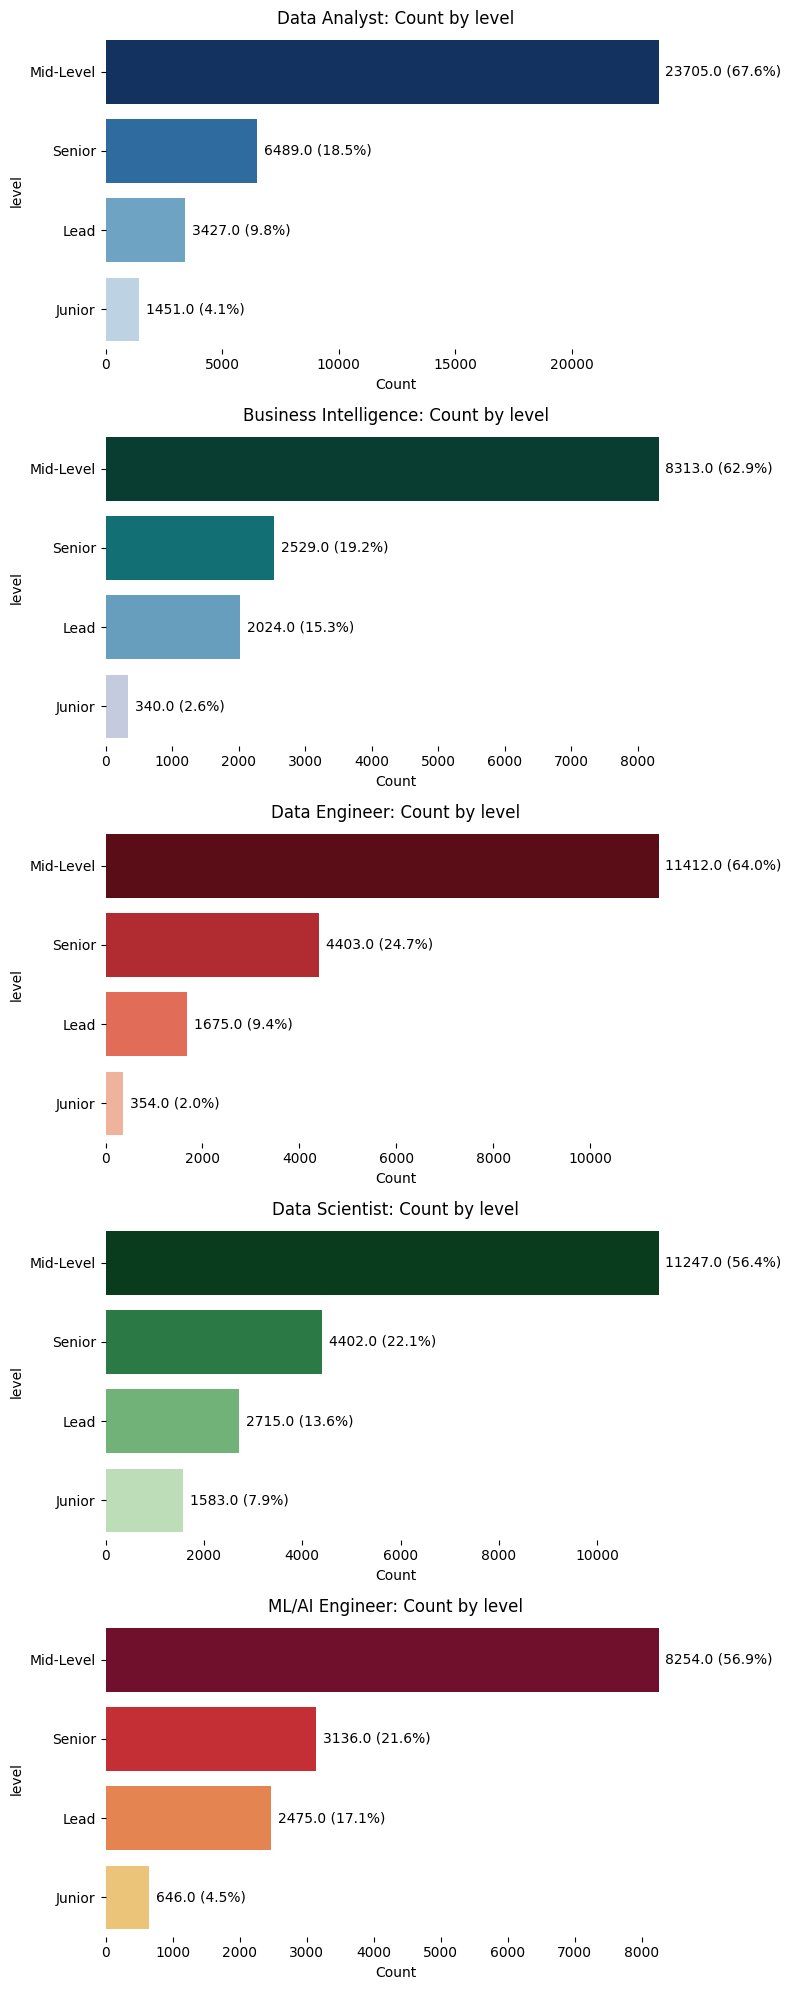

In [119]:
plot_multiple_bars(df_data, columns_level,category='job_group',figsize=(8,20),count_percentage=True)

## Salary by Skills

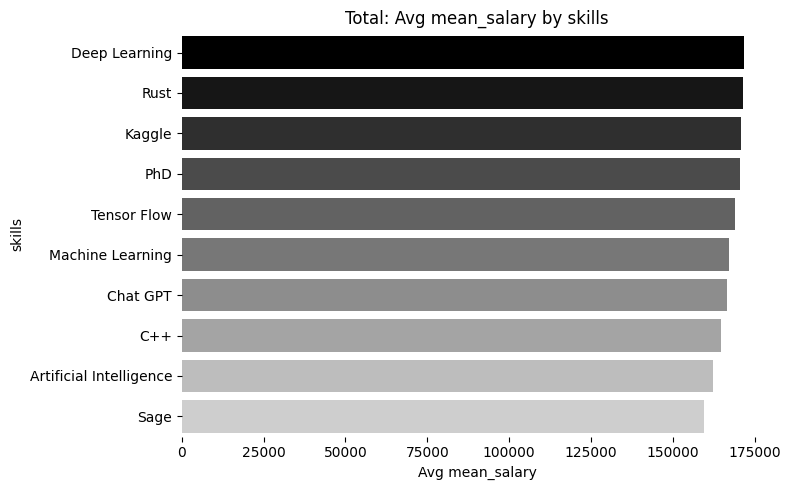

In [120]:
plot_multiple_bars(df_data, columns_skills,figsize=(8,5), list_values=True, top_10=True, aggregate_column='mean_salary')

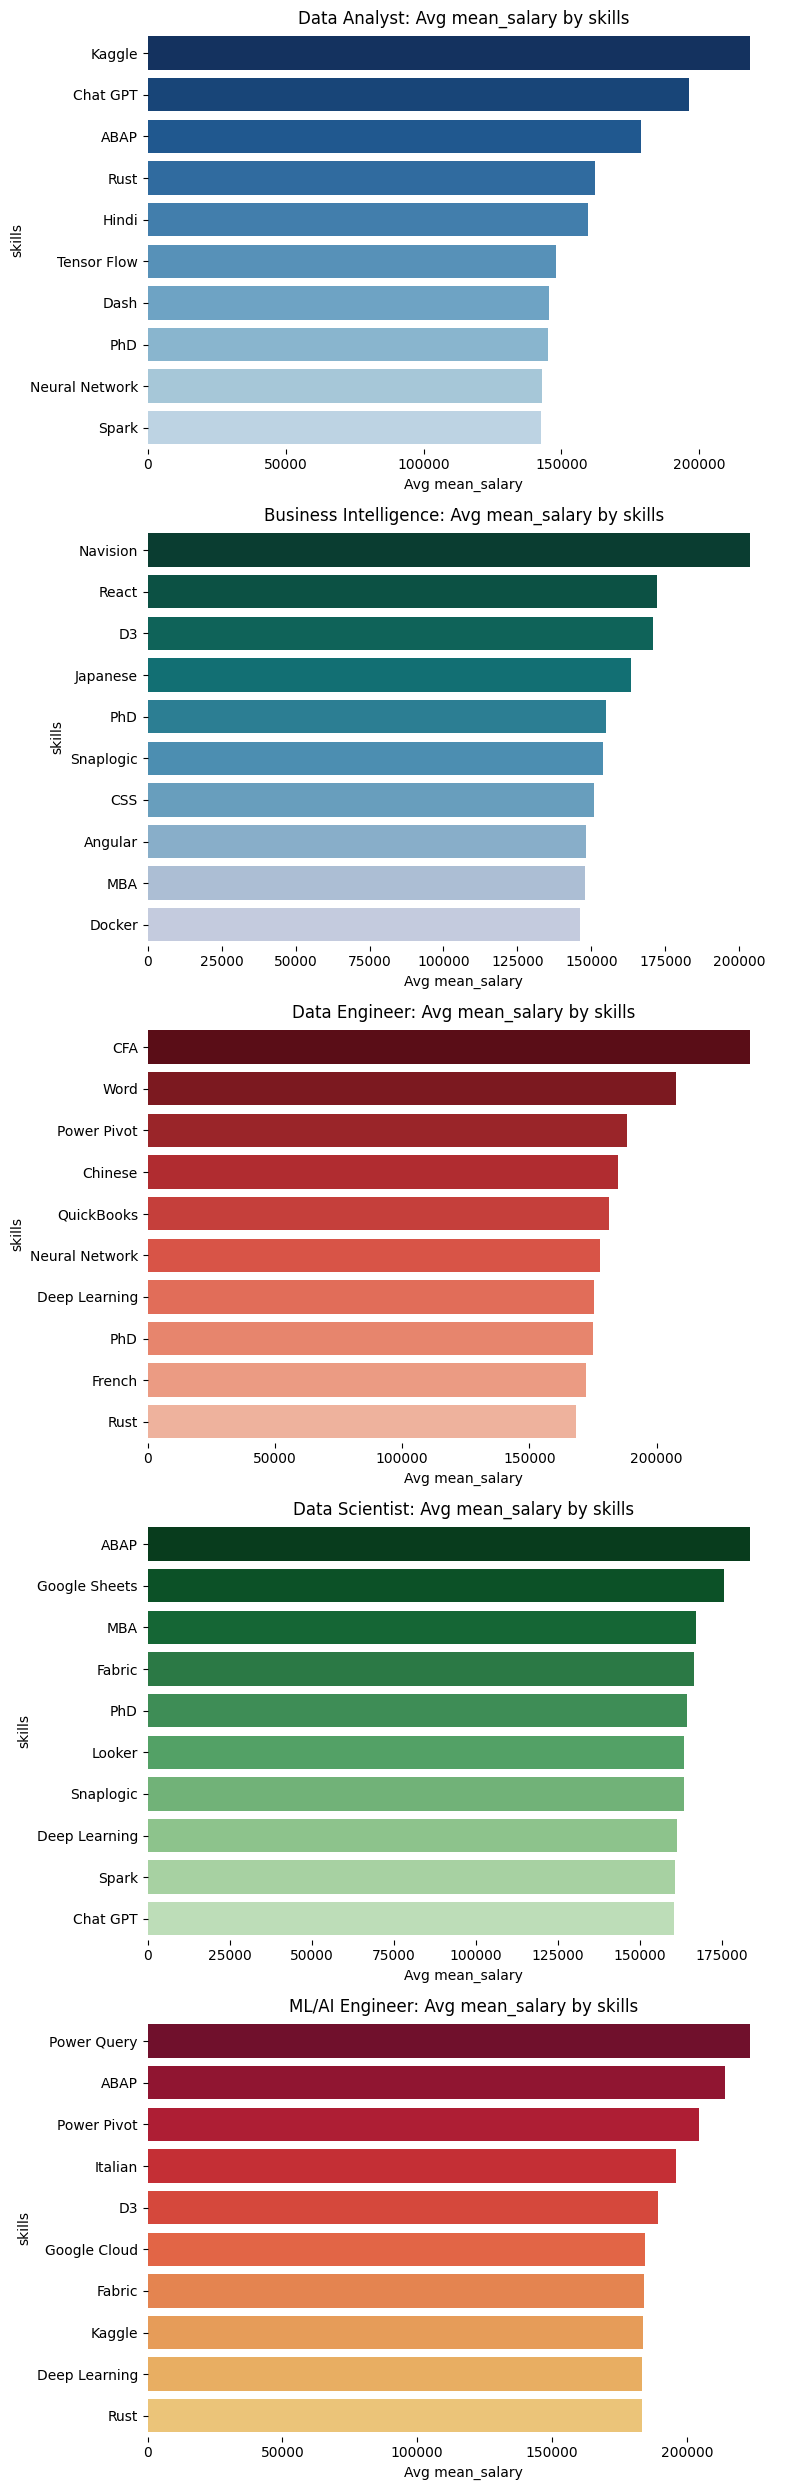

In [122]:
plot_multiple_bars(df_data, columns_skills, category='job_group',figsize=(8,25), list_values=True, top_10=True, aggregate_column='mean_salary')

## Programming Languages most demanded

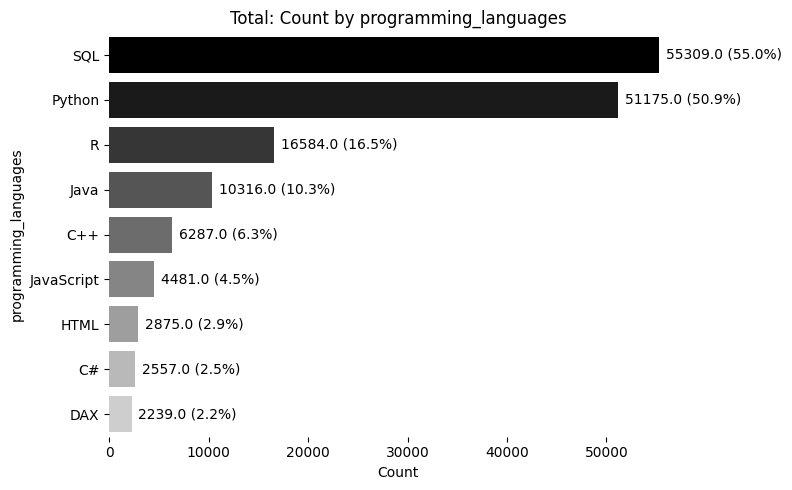

In [125]:
columns_programming_language = ['programming_languages',]
plot_multiple_bars(df_data, columns_programming_language,figsize=(8,5), list_values=True, count_percentage=True, top_10=True)

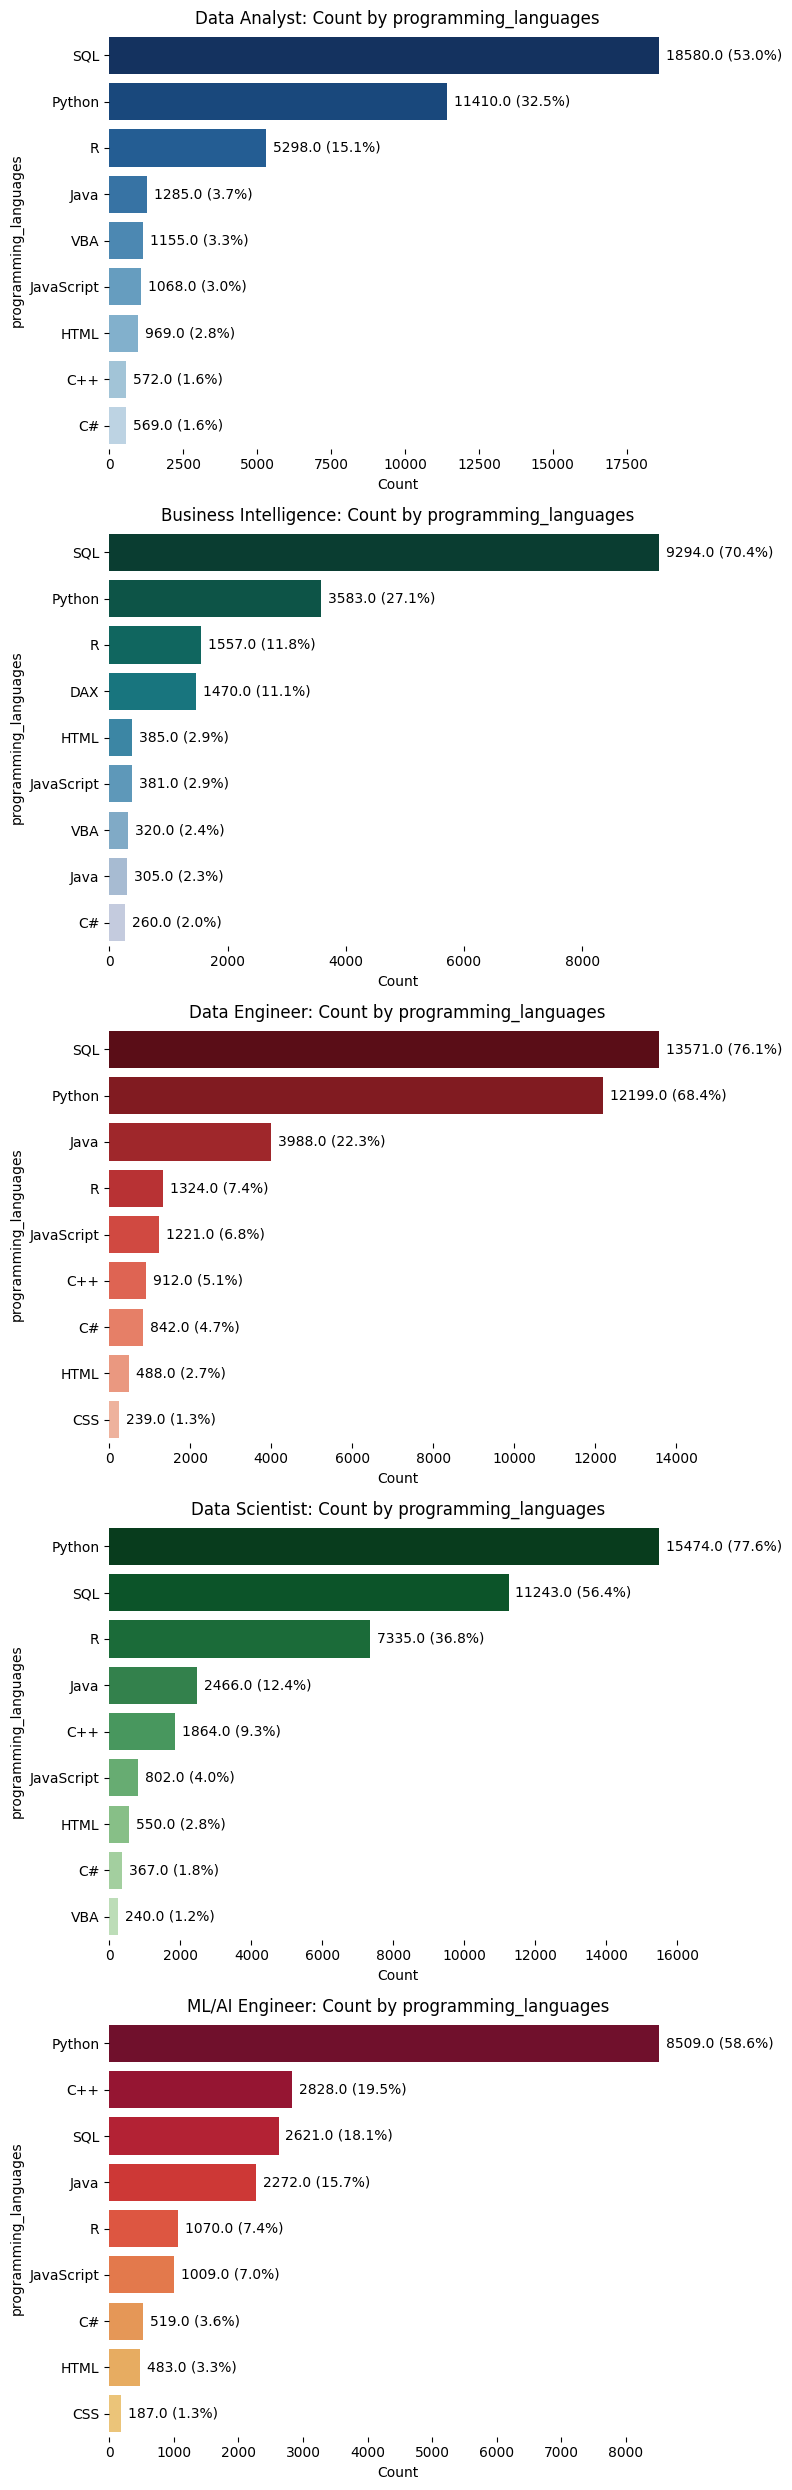

In [130]:
plot_multiple_bars(df_data, columns_programming_language, category = 'job_group',figsize=(8,25), list_values=True, count_percentage=True, top_10=True)

## Tableau vs Power BI (by job group)

## R vs Python (by job group)

## Count by Location

## Salaries 2024 vs 2023

# Finance

## Count by Level

## Salary by Skills

## Skills most demanded

## CPA vs no CPA (Count)

## CPA vs no CPA (Salary)

## SAP vs Oracle (Count)

## Salaries 2024 vs 2023